In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
keyword = "diagnostic device"
num_articles = 100
encodingmethod = "utf-8"
errortype = "strict"

In [6]:
import urllib.parse
import urllib.request
import xml.etree.ElementTree as ET

encoded_search_term = urllib.parse.quote(keyword, encoding=encodingmethod, errors=errortype)
url = f'http://export.arxiv.org/api/query?search_query=all:{encoded_search_term}&start=0&max_results={num_articles}'

print(f"Searching for '{keyword}' on arXiv...")
print(f"URL: {url}")

try:
    response = urllib.request.urlopen(url)
    try:
        url_read = response.read().decode("utf-8")
    except UnicodeDecodeError:
        response = urllib.request.urlopen(url)
        url_read = response.read().decode("utf-8", errors="ignore")

    parse_xml = ET.fromstring(url_read)
    print("Successfully retrieved search results!")
except Exception as e:
    print(f"Error retrieving data: {e}")
    raise

Searching for 'diagnostic device' on arXiv...
URL: http://export.arxiv.org/api/query?search_query=all:diagnostic%20device&start=0&max_results=100
Successfully retrieved search results!


In [7]:
ns = {"ns": "http://www.w3.org/2005/Atom"}
entries = parse_xml.findall('ns:entry', ns)

articles_data = []
for entry in entries:
    link = entry.find('ns:link[@type="application/pdf"]', ns)
    if link is not None and "href" in link.attrib:
        pdf_url = link.attrib['href']

        title = entry.find('ns:title', ns)
        title_text = title.text.strip() if title is not None else "Unknown Title"

        authors = entry.findall('ns:author/ns:name', ns)
        author_names = [author.text for author in authors] if authors else ["Unknown Author"]

        published = entry.find('ns:published', ns)
        published_date = published.text[:10] if published is not None else "Unknown Date"

        summary = entry.find('ns:summary', ns)
        summary_text = summary.text.strip() if summary is not None else "No summary available"

        metadata = {
            'title': title_text,
            'authors': author_names,
            'published': published_date,
            'summary': summary_text
        }

        articles_data.append({
            'pdf_url': pdf_url,
            'metadata': metadata
        })

print(f"Found {len(articles_data)} articles with PDF links")
for i, article in enumerate(articles_data):
    print(f"{i+1}. {article['metadata']['title'][:80]}...")

Found 100 articles with PDF links
1. An Electrochemical Potentiostat Interface for Mobile Devices: Enabling
  Remote ...
2. Practical Statistical Considerations for the Clinical Validation of
  AI/ML-enab...
3. Cross-device Federated Learning for Mobile Health Diagnostics: A First
  Study o...
4. Random Forests for Industrial Device Functioning Diagnostics Using
  Wireless Se...
5. D-Mag: a laboratory for studying plasma physics and diagnostics in
  strong magn...
6. Noninvasive Acute Compartment Syndrome Diagnosis Using Random Forest
  Machine L...
7. Diagnostic criterion for crystallized beams...
8. Plasma diagnostics using digital holographic interferometry...
9. Bioimpedance a Diagnostic Tool for Tobacco Induced Oral Lesions: a Mixed
  Model...
10. Active Sampling for MRI-based Sequential Decision Making...
11. Conceptual Study of a Collective Thomson Scattering Diagnostic for SPARC...
12. Integrated Data Analysis and Validation...
13. Special behavior of alkali beam emission spect

In [13]:
!pip install faiss-cpu
!pip install pypdf2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.9 MB/s eta 0:00:00


In [14]:
from sentence_transformers import SentenceTransformer
import faiss

dimension = 768
model = SentenceTransformer('pritamdeka/S-BioBert-snli-multinli-stsb')
chunk_index = faiss.IndexFlatL2(dimension)

In [15]:
import numpy as np
def cos_sim(e1, e2):
    return np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2))

In [16]:
import requests
from PyPDF2 import PdfReader
import nltk
import io

chunks = []
chunk_size_sentences = 50

for i, article in enumerate(articles_data):
    try:
        pdf_response = requests.get(article['pdf_url'], timeout=30)
        pdf_response.raise_for_status()

        pdf_file = io.BytesIO(pdf_response.content)
        pdf_reader = PdfReader(pdf_file)
        pdf_text = ""

        for page in pdf_reader.pages:
            page_text = page.extract_text()
            if page_text and page_text.strip():
                pdf_text += page_text + " "

        pdf_text = re.sub(r' {2,}', ' ', pdf_text)
        pdf_text = re.sub(r'\n{3,}', '\n\n', pdf_text)
        pdf_text = re.sub(r'[\f\v\r]', ' ', pdf_text)
        pdf_text = re.sub(r'[\x00-\x08\x0B\x0C\x0E-\x1F\x7F]', '', pdf_text)
        pdf_text = re.sub(r'([.!?])\s*([A-Z])', r'\1 \2', pdf_text)
        pdf_text = pdf_text.strip()

        sentences = nltk.sent_tokenize(pdf_text)
        num_sentences = len(sentences)

        for j in range(0, num_sentences, chunk_size_sentences):
            chunk_sentences = sentences[j:j + chunk_size_sentences]
            chunk_text = " ".join(chunk_sentences)

            if chunk_text:
                chunk_embedding = model.encode(chunk_text, convert_to_tensor=True)
                chunk_embedding = chunk_embedding.cpu().numpy().astype('float32')

                chunk_data = {
                    'text': chunk_text,
                    'embedding': chunk_embedding,
                    'metadata': article['metadata'],
                    'sentence_count': len(chunk_sentences)
                }
                chunks.append(chunk_data)

    except Exception as e:
        print(f"Error processing article {i+1}: {str(e)}")

/usr/local/lib/python3.11/dist-packages/PyPDF2/_cmap.py:142: PdfReadWarning: Advanced encoding /SymbolSetEncoding not implemented yet
  warnings.warn(


In [17]:
for chunk in chunks:
    chunk_index.add(chunk['embedding'].reshape(1, -1))

In [18]:
chunks[0]

{'text': '1 \n An Electrochemical Potentiostat Interface for Mobile Devices : Enabling \nRemote Medical Diagnostics \nHenry Fu, Henry Chow, Michael Lew, Shruti Menon, Craig Scratchley, M. Ash Parameswaran \nAbstract \nAn electrochemical potentiostat interface for mobile devices has been designed and \nimplemented. The interface consists of a potentiostat module, a microcontroller module , and a \nBluetooth module. The potentiostat module performs electrochemical measurements and detects \nthe response s from the samples. The microcontro ller module controls the test and \ncommunication processes. The Bluetooth module links the system to a mobile device, where the \nmobile device acts as a control -console, data storage system , communication unit , and graphica l \nplotter for the overall diagnosti c processes. This interface is suitable for point -of-care and remote \ndiagnostics , enhanc ing the capabilities of mobile devices in telemedicine. Keywords \nMobile device; Remote medical 

In [19]:
faiss.write_index(chunk_index, "chunks.index")

In [22]:
import networkx as nx
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import spacy
import re

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
nlp = pipeline("ner", model=model, tokenizer=tokenizer)
print("BioBERT NER model loaded.")


def extract_relationships(entities, text, window_size=50):
    relationships = []
    sorted_entities = sorted(entities, key=lambda x: x['start'])

    for i in range(len(sorted_entities)):
        for j in range(i + 1, len(sorted_entities)):
            entity1 = sorted_entities[i]
            entity2 = sorted_entities[j]

            # Use 'entity' key instead of 'entity_group'
            if (entity2['start'] - entity1['end'] < window_size) and (entity1['entity'] != entity2['entity']):
                relationship_type = f"{entity1['entity']}_RELATED_TO_{entity2['entity']}"
                relationships.append({
                    'source': entity1,
                    'target': entity2,
                    'type': relationship_type,
                    'text_context': text[max(0, entity1['start'] - 50):min(len(text), entity2['end'] + 50)]
                })
    return relationships

all_relationships = []
entities_by_chunk = {}

for i, chunk in enumerate(chunks):
    text = chunk['text']
    entities_in_chunk = nlp(text)

    entities_by_chunk[i] = entities_in_chunk
    for entity in entities_in_chunk:
        entity['chunk_index'] = i

    relationships_in_chunk = extract_relationships(entities_in_chunk, text)
    all_relationships.extend(relationships_in_chunk)

print(f"Extracted {len(all_relationships)} potential relationships using rule-based approach.")

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


BioBERT NER model loaded.


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Extracted 164858 potential relationships using rule-based approach.


In [23]:
G = nx.DiGraph()

node_mapping = {}

for chunk_index, entities in entities_by_chunk.items():
    for entity in entities:
        node_id = f"{chunk_index}_{entity['start']}_{entity['word']}"
        if node_id not in node_mapping:
            # Use 'entity' key instead of 'entity_group'
            G.add_node(node_id, text=entity['word'], type=entity['entity'],
                       start=entity['start'], end=entity['end'], score=entity['score'],
                       chunk_index=chunk_index, metadata=chunks[chunk_index]['metadata'])
            node_mapping[node_id] = node_id

for rel in all_relationships:
    source_entity = rel['source']
    target_entity = rel['target']

    source_node_id_partial = f"{source_entity['chunk_index']}_{source_entity['start']}_{source_entity['word']}"
    target_node_id_partial = f"{target_entity['chunk_index']}_{target_entity['start']}_{target_entity['word']}"


    if source_node_id_partial in node_mapping and target_node_id_partial in node_mapping:
         G.add_edge(node_mapping[source_node_id_partial], node_mapping[target_node_id_partial], relation=rel['type'])


print(f"Created NetworkX graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Created NetworkX graph with 39967 nodes and 164858 edges.


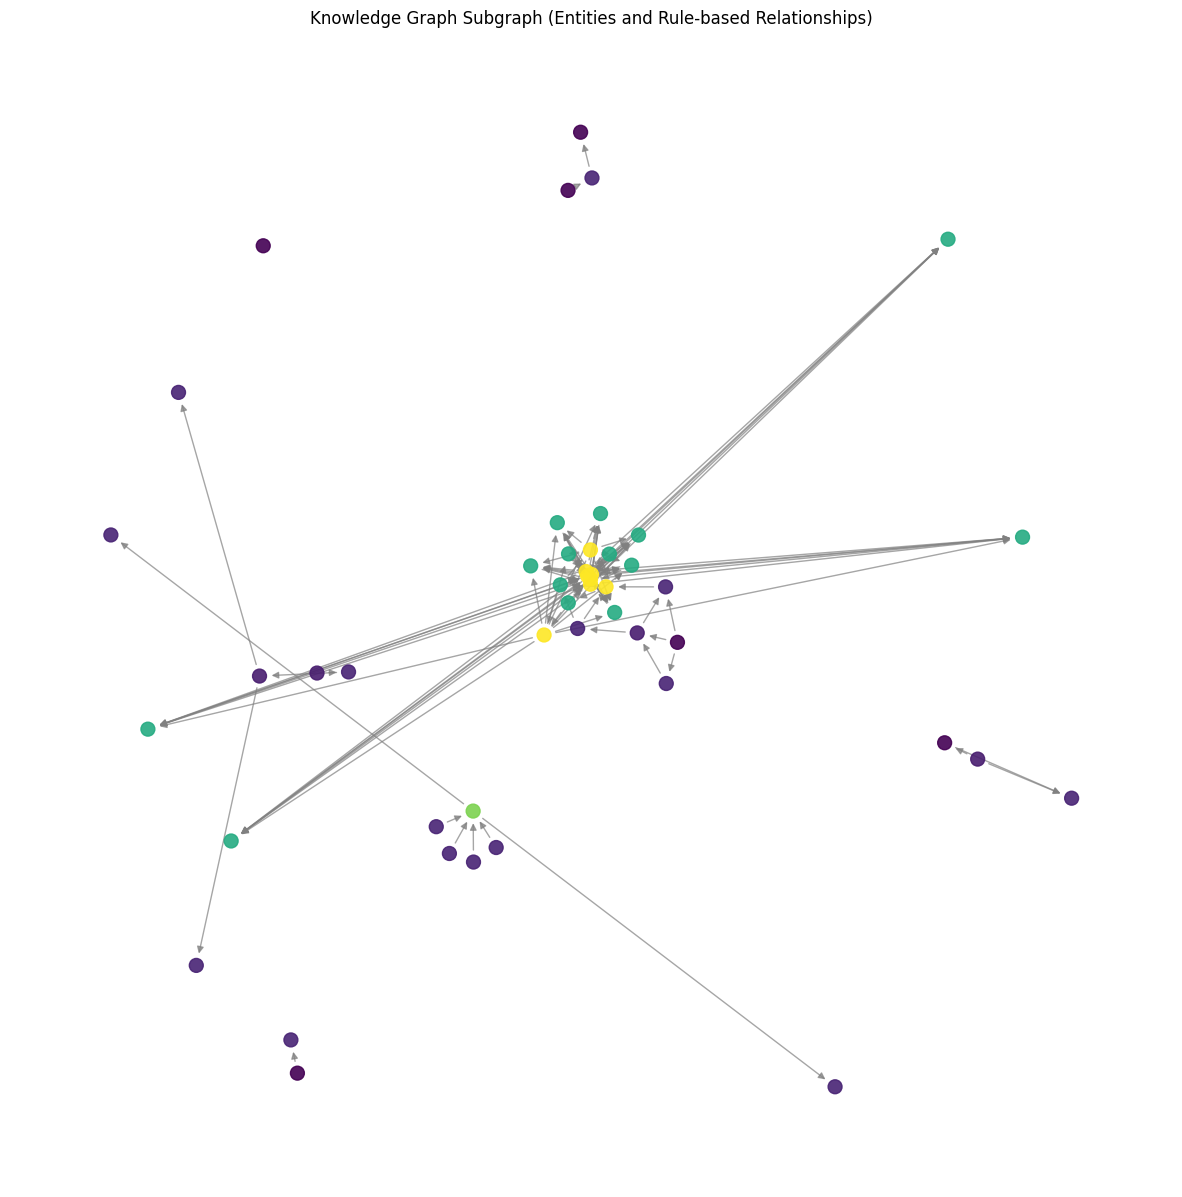

In [24]:
nodes_to_visualize_subgraph = [node_id for node_id, data in G.nodes(data=True) if data['chunk_index'] < 3]
subgraph_to_visualize = G.subgraph(nodes_to_visualize_subgraph)

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(subgraph_to_visualize)

node_colors = [hash(data['type']) % plt.cm.viridis.N for node, data in subgraph_to_visualize.nodes(data=True)]
nx.draw_networkx_nodes(subgraph_to_visualize, pos, node_size=100, node_color=node_colors, cmap=plt.cm.viridis, alpha=0.9)
nx.draw_networkx_edges(subgraph_to_visualize, pos, width=1.0, alpha=0.7, edge_color='gray')

plt.title("Knowledge Graph Subgraph (Entities and Rule-based Relationships)")
plt.axis('off')
plt.show()

In [25]:
nx.write_gexf(G, "knowledge_graph.gexf")

In [26]:
#TODO: Better NER and ER

In [27]:
G = nx.read_gexf("knowledge_graph.gexf")

In [28]:
#TODO: Tag each chunk with the entities they have

In [29]:
len(chunks)

866

In [30]:
len(entities_by_chunk)

866

In [31]:
entities_by_chunk[0]

[{'entity': 'B-MISC',
  'score': np.float32(0.49840963),
  'index': 3,
  'word': 'El',
  'start': 7,
  'end': 9,
  'chunk_index': 0},
 {'entity': 'I-MISC',
  'score': np.float32(0.6662141),
  'index': 6,
  'word': '##chemical',
  'start': 14,
  'end': 22,
  'chunk_index': 0},
 {'entity': 'I-ORG',
  'score': np.float32(0.42714632),
  'index': 10,
  'word': '##ost',
  'start': 30,
  'end': 33,
  'chunk_index': 0},
 {'entity': 'I-MISC',
  'score': np.float32(0.8271744),
  'index': 16,
  'word': 'Devi',
  'start': 57,
  'end': 61,
  'chunk_index': 0},
 {'entity': 'I-MISC',
  'score': np.float32(0.4883649),
  'index': 17,
  'word': '##ces',
  'start': 61,
  'end': 64,
  'chunk_index': 0},
 {'entity': 'B-PER',
  'score': np.float32(0.9997359),
  'index': 29,
  'word': 'Henry',
  'start': 105,
  'end': 110,
  'chunk_index': 0},
 {'entity': 'I-PER',
  'score': np.float32(0.9996132),
  'index': 30,
  'word': 'Fu',
  'start': 111,
  'end': 113,
  'chunk_index': 0},
 {'entity': 'B-PER',
  'score'

In [32]:
for i, chunk in enumerate(chunks):
  if i in entities_by_chunk:
    chunk["entities"] = entities_by_chunk[i]

In [35]:
import json
import numpy as np

json_serializable_chunks = []
for chunk in chunks:
    serializable_chunk = chunk.copy()
    if 'embedding' in serializable_chunk and isinstance(serializable_chunk['embedding'], np.ndarray):
        serializable_chunk['embedding'] = serializable_chunk['embedding'].tolist()

    if 'entities' in serializable_chunk:
        serializable_chunk['entities'] = [{
            'entity': entity['entity'], # Use 'entity' key
            'score': float(entity['score']) if isinstance(entity['score'], np.float32) else entity['score'],
            'word': entity['word'],
            'start': entity['start'],
            'end': entity['end'],
            'chunk_index': entity['chunk_index']
        } for entity in serializable_chunk['entities']]

    json_serializable_chunks.append(serializable_chunk)


with open("chunks_with_entities.json", "w") as f:
  json.dump(json_serializable_chunks, f, indent=4)

In [33]:
chunks[0]

{'text': '1 \n An Electrochemical Potentiostat Interface for Mobile Devices : Enabling \nRemote Medical Diagnostics \nHenry Fu, Henry Chow, Michael Lew, Shruti Menon, Craig Scratchley, M. Ash Parameswaran \nAbstract \nAn electrochemical potentiostat interface for mobile devices has been designed and \nimplemented. The interface consists of a potentiostat module, a microcontroller module , and a \nBluetooth module. The potentiostat module performs electrochemical measurements and detects \nthe response s from the samples. The microcontro ller module controls the test and \ncommunication processes. The Bluetooth module links the system to a mobile device, where the \nmobile device acts as a control -console, data storage system , communication unit , and graphica l \nplotter for the overall diagnosti c processes. This interface is suitable for point -of-care and remote \ndiagnostics , enhanc ing the capabilities of mobile devices in telemedicine. Keywords \nMobile device; Remote medical 